In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import sys

### Constants
* $L_v = 2.5 × 10^6 [J-kg^{−1}]$  latent heat of vaporization
* $R_d = 287.04 [J-kg^{-1}-K^{-1}]$  gas constant for dry air
* $c_v = 718 [J-kg^{-1}-K^{-1}]$  specific heat of dry air at constant volume 
* $c_p = c_v + R_d [J-kg^{-1}-K^{-1}]$  specific heat of dry air at constant pressure 
* $c_l = 4190 [J-kg^{-1}-K^{-1}]$ specific heat of liquid water 
* $e_0 = 611.65 [Pa]$ pressure at triple point
* $T_{trip} = 273.16 [K]$ temperature at triple point
* $R_v = 461.5 [J-kg^{-1}-K^{-1}]$  gas constant for vapor

## Enthalpy-base calculation of potential intensity
<i>Note:</i> This is following the introductory material of Rousseau-Rizzi et al. (2022) (doi:https://doi.org/10.1175/JCLI-D-21-0360.1): 
$$ PI^2_k \approx \frac{c_k}{c_d} \frac{\left(T_s - T_o\right)}{T_o} \left(k^∗_s − k_a\right), $$

where $T_s$ is sea surface temperature and $T_o$ is temperature at the outflow layer. $k$ is moist enthalpy, and $k^*_s - k_a$ is the moist enthalpy difference between the sea surface ($k^∗_s$), and the air surface ($k_a$). Recall that in general,

$$ k = c_p\cdot T + L\cdot r, $$

where $r$ is the water vapor mixing ratio (g/kg). So enthalpy at the sea surface, $k^*_s$, can be calculated, 

$$k^∗_s = c_p\cdot T_s + L\cdot r^∗\left(T_s\right),$$

where $T_s$ is sea surface temperature. Similarly, enthalpy of the atmosphere above the surface is, 

$$k_a = c_p\cdot T_a + L\cdot r_a.$$


We can estimate $r$ as a function of temperature, $T$, and pressure, $p$. We'll use the simplified Paul O'Gorman formulation for now, where we assume no ice and constant $L_v$.  

$$e_s = e_0 \times \exp{\frac{L_v}{R_v \times \left(\frac{1.0}{T_{trip}} - \frac{1.0}{T}\right)}}$$
$$r_s = \frac{R_d}{R_v}\times \frac{e_s}{(p - e_s)}$$

So once we can calculate $r$, we can calculate $k$, and thus, we can calculate $PI_k$. 

## CAPE-based calculation of potential intensity
$$ MPI^2_{CAPE} = MPI^2_k + \left(\frac{c_k}{c_d}\right) \frac{T_s}{T_o} \left[c_l\times T_o\times \ln{\left(\frac{T_o}{T_s}\right)}\left(r_s^* - r_b\right) \right],$$

where $r_b$ is $r$ at boundary layer. If we assume a well-mixed BL, we'll assume $r_b$ and $r_a$ are the same. 

<b>Assume</b> that $\frac{c_k}{c_d} \approx 1$, though this is probably not strictly true.

### Calculate k- and CAPE-based MPI

In [2]:
# Inputs:
# Ta: temperature at atmospheric surface (for SHIPS, use T000 as default)
# Ts: sea surface temperature (for SHIPS, use RSST as default)
# To: temperature at outflow (for SHIPS, use T150 as default)
# pa: pressure at atmospheric surface in [Pa] (use 10e5 if we use T000)
# ps: pressure at sea surface [Pa] (use MSLP for SHIPS)
#
# Outputs:
# pi_k: enthalpy-based PI calculation
# pi_CAPE: CAPE-based PI calculation
def calculate_MPI(Ta,Ts,To,pa,ps):
    # Thermodynamic constants
    Rd = 287.04
    Lv = 2.5e6
    Rv = 461.5
    Ttrip = 273.16
    e0 = 611.65
    cv = 718
    cl = 4190 
    cp = cv + Rd
    C_to_K = 273.15
    # Get saturation vapor pressure and mixing ratio
    def calc_es_rs(T,p):
        es = e0 * np.exp(Lv/Rv*(1.0/Ttrip - 1.0/T))
        rs = Rd/Rv*es/(p - es)
        return es,rs
    # Get values of enthalpy
    def calc_k(T,r):
        k = cp*T + Lv*r
        return k
    # Calculate PI based on enthalpy
    def calc_PI(Ts,To,k_s,k_a):
        pik2 = ((Ts-To)/To)*(k_s-k_a)
        pi = np.sqrt(pik2)
        return pi
    # Calculate CAPE-based PI
    def calc_CAPE_PI(To,Ts,r_s,r_a,pi_k):
        term = cl*To*np.log(To/Ts)*(r_s - r_a)
        MPI_cape = np.sqrt(pi_k**2 + (Ts/To)*term)
        return MPI_cape
    # Convert temperatures to Kelvin
    Ta = Ta + C_to_K
    Ts = Ts + C_to_K
    To = To + C_to_K
    # Get es,rs
    es_a,rs_a = calc_es_rs(Ta,pa)
    es_s,rs_s = calc_es_rs(Ts,ps)
    # Get k
    k_s = calc_k(Ts,rs_s)
    k_a = calc_k(Ta,rs_a)
    # enthalpy PI
    pi_k = calc_PI(Ts,To,k_s,k_a)
    # CAPE PI
    pi_CAPE = calc_CAPE_PI(To,Ts,rs_s,rs_a,pi_k)
    return pi_k,pi_CAPE

### 1. Load preprocessed data

In [3]:
interp_str = 'INTERP'
fname_save = 'DATA/SHIPS_processed_ALL_BASINS_I_scaled_landmask_{interp_str}.csv'.format(interp_str=interp_str)
SHIPS_load = pd.read_csv('DATA/SHIPS_file_full_clim_invar.csv')

In [4]:
Rd = 287.04
Lv = 2.5e6
Rv = 461.5
Ttrip = 273.16
e0 = 611.65
cv = 718
cl = 4190 
cp = cv + Rd
C_to_K = 273.15  # factor to convert celsius to kelvin

For surface air temperature ($T_a$), we'll use the `T000` SHIPS predictor ($T$ at 1000 hPa). This means $p_a$ will be 1000 hPa, or 10e5 Pa. For outflow temperature, $T_o$, we'll use the SHIPS variable `T150`. For sea surface temperature ($T_s$) we'll use `RSST` (for now) and for pressure at sea surface we'll use `MSLP` (multiplied by 100 to convert it from hPa to Pa).   

In [5]:
SHIPS_load['pa'] = 10e5
SHIPS_load['ps'] = SHIPS_load['MSLP']*100

#### Mask NaNs

In [6]:
SHIPS_load = SHIPS_load.mask(SHIPS_load == 9999.0)

### Calculate PI

In [7]:
PI_en,PI_cape = calculate_MPI(SHIPS_load['T000'],SHIPS_load['RSST'],SHIPS_load['T150'],10e5,SHIPS_load['MSLP']*100)

/home/mmcgraw/miniconda3/envs/SHIPS/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [12]:
SHIPS_load['PI_k'] = PI_en
SHIPS_load['PI_cape'] = PI_cape


### How well do original SHIPS PI, k-based, and CAPE-based PI correlated? 
* original: `VMPI`
* $k$-based: `PI_k`
* CAPE-based: `PI_cape`

Look at overall correlation as well as max, min, mean, and median values on a per-storm basis

In [62]:
corr_mean = SHIPS_load[['VMPI','PI_k','PI_cape']].corr()
print(corr_mean)
# Get max, min, and mean values of 
corr_max_storm = SHIPS_load.groupby(['ATCF ID'])[['VMPI','PI_k','PI_cape']].max().corr()
corr_min_storm = SHIPS_load.groupby(['ATCF ID'])[['VMPI','PI_k','PI_cape']].min().corr()
corr_mean_storm = SHIPS_load.groupby(['ATCF ID'])[['VMPI','PI_k','PI_cape']].mean().corr()
corr_med_storm = SHIPS_load.groupby(['ATCF ID'])[['VMPI','PI_k','PI_cape']].median().corr()


             VMPI      PI_k  PI_cape
VMPI     1.000000  0.927454  0.92658
PI_k     0.927454  1.000000  0.99667
PI_cape  0.926580  0.996670  1.00000


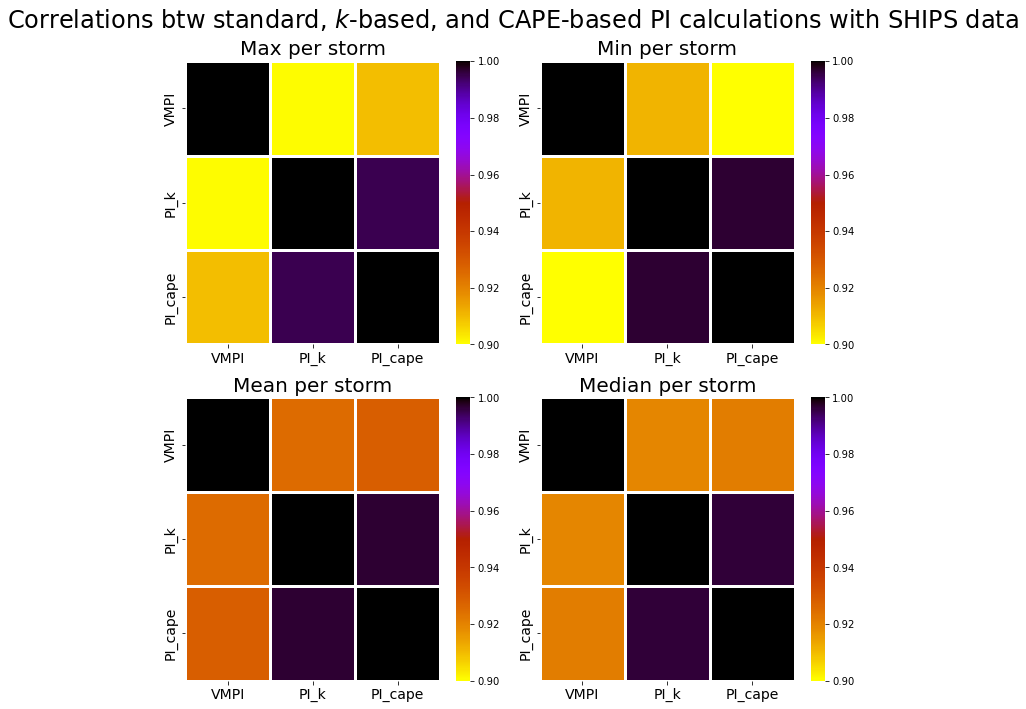

In [75]:
fig1,((ax1a,ax1b),(ax1c,ax1d)) = plt.subplots(2,2,figsize=(10,10))
#
sns.heatmap(corr_max_storm,ax=ax1a,cmap='gnuplot_r',vmin=0.9,vmax=1,linewidth=3)
ax1a.set_title('Max per storm',fontsize=20)
#
sns.heatmap(corr_min_storm,ax=ax1b,cmap='gnuplot_r',vmin=0.9,vmax=1,linewidth=3)
ax1b.set_title('Min per storm',fontsize=20)
#
sns.heatmap(corr_mean_storm,ax=ax1c,cmap='gnuplot_r',vmin=0.9,vmax=1,linewidth=3)
ax1c.set_title('Mean per storm',fontsize=20)
#
sns.heatmap(corr_med_storm,ax=ax1d,cmap='gnuplot_r',vmin=0.9,vmax=1,linewidth=3)
ax1d.set_title('Median per storm',fontsize=20)
#
ax1a.tick_params(axis='both',labelsize=14)
ax1b.tick_params(axis='both',labelsize=14)
ax1c.tick_params(axis='both',labelsize=14)
ax1d.tick_params(axis='both',labelsize=14)
#
fig1.suptitle('Correlations btw standard, $k$-based, and CAPE-based PI calculations with SHIPS data',fontsize=24)
fig1.tight_layout()
